# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

# Steps


In [147]:
# Import everything
import math
import numpy as np
from matplotlib import pyplot as plt
from g2o_fhdlr.read_se2 import read_vertex, read_edges_olc
from g2o_fhdlr.write_se2 import write_vertex

## Part 1: Generate and Visualize Vertices

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.



If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

### Intuition for odometry

The transformation was obtained using the following frame transformations. Assume that the current vertex/pose is $(x, y, \theta) = \{A\}$ and the transform of $(\Delta x,\Delta y,\Delta \theta)$ (local to $\{A\}$) yield $\{B\}$. We're interested in knowing the frame $\{B\}$ in the global frame $\{O\}$ (in which all vertices, like $\{A\}$ are described). This is done using (trigonometric angles are abbreviated)

$$
^{O}_{B}\textup{T} = ^{O}_{A}\textup{T} \; ^{A}_{B}\textup{T} = \begin{bmatrix}
c\theta & -s\theta & x \\
s\theta & c\theta & y \\
0 & 0 & 1
\end{bmatrix} \; \begin{bmatrix}
c\Delta\theta & -s\Delta\theta & \Delta x \\
s\Delta\theta & c\Delta\theta & \Delta y \\
0 & 0 & 1
\end{bmatrix} = \begin{bmatrix}
c(\theta+\Delta\theta) & -s(\theta+\Delta\theta) & x + \Delta x \, c\theta - \Delta y \, s\theta \\
s(\theta+\Delta\theta) & c(\theta+\Delta\theta) & y + \Delta x \, s\theta + \Delta y \, c\theta \\
0 & 0 & 1
\end{bmatrix}
$$

This gives $\{B\} = (x + \Delta x \, c\theta - \Delta y \, s\theta \;,\; y + \Delta x \, s\theta + \Delta y \, c\theta \;,\; \theta+\Delta\theta)$

We will read the starting vertex and odometry edges, then construct the resulting vertices, then save everything in a file.


### Reading the files

Set the `file_mea` and `file_gt` variables as path to measurement (odometry) and ground truth vertices file.

In [148]:
# Set variables
file_mea = "./../data/edges.txt"   # File containing measurement data
file_gt = "./../data/gt.txt"    # File containing ground truth
st_vertex = 0   # Starting vertex (also assumed fixed)

In [149]:
# Read starting vertex
stv = read_vertex(file_mea, True)[st_vertex]
# Read odometry and loop closure constraints
odom_c, lc_c = read_edges_olc(file_mea)
# Read the ground truth
vgt = read_vertex(file_gt, True)
x_gt = vgt[:,1:4]   # Ground truth poses

In [150]:
def motion_model(u_vals, x_vals):
    """
    Motion model of the robot. Returns new 'x' (states) given the
    previous state 'x_vals' and the control action 'u_vals'    

    Parameters:
    - u_vals: [dx, dy, dth]:    Control action
    - x_vals: [x, y, th]:       Current (to-be-previous) state

    Returns:
    - nx_vals: [nx, ny, nth]:   New (to-be-current) state
    """
    dx, dy, dth = u_vals
    x, y, th = x_vals
    nx = x + dx * np.cos(th) - dy * np.sin(th)
    ny = y + dx * np.sin(th) + dy * np.cos(th)
    nth = th + dth
    nx_vals = np.array([nx, ny, nth])
    return nx_vals


In [151]:
# All processing (for get x_mea from odom measurements)
X0 = stv[1:4]  # First pose
x_mea = []  # Collection of pose
u_mea = []  # Store the measured odometry
x_mea.append(X0)
# Generate odometry
for p, tf, ci in odom_c:
    u_mea.append(tf)    # Record odometry
    # New X value using motion model
    nx_vals = motion_model(tf, x_mea[-1])
    x_mea.append(nx_vals)
# Convert to numpy arrays
u_mea = np.array(u_mea) # Odometry (measurements)
x_mea = np.array(x_mea) # State (measurements)

### Visualizing data

The `draw` function is modified to use [quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) and plot. It also allows us to handle subplots externally.

In [152]:
# A function to visualize the data
def draw(x_vals):
    """
    Draw the 'x' state values. x_vals = [x, y, th] array
    """
    x, y, th = x_vals[:, 0], x_vals[:, 1], x_vals[:, 2]
    u, v = np.cos(th), np.sin(th)
    plt.plot(x, y, '.')
    plt.quiver(x, y, u, v)
    plt.plot(x[0], y[0], 'rx', label="start")
    plt.plot(x[-1], y[-1], 'gx', label="end")

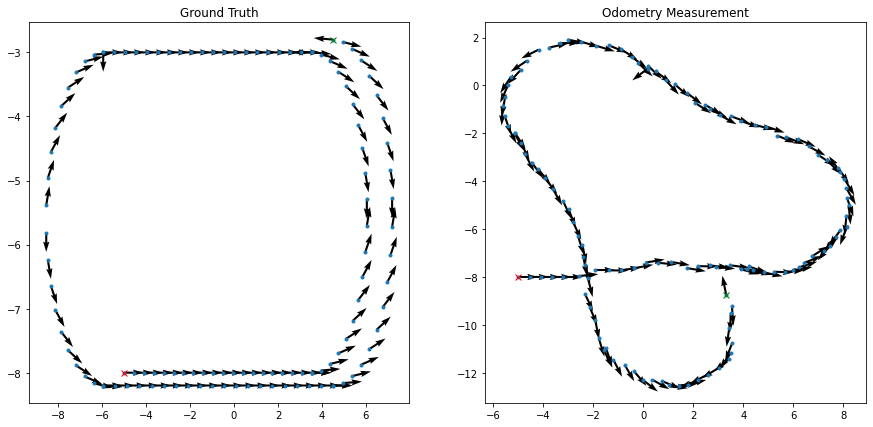

In [153]:
# Show data
plt.figure(1, (15, 7))
plt.subplot(121)
plt.title("Ground Truth")
draw(x_gt)
plt.subplot(122)
plt.title("Odometry Measurement")
draw(x_mea)

**Interpretation**

The starting point is shown by red cross, ending point by green cross. The headings are shown as arrows at every point.

It appears that there are some angle jumps in the data. This could be because of the noise in IMU (which was probably used for heading). This can be noticed as sudden angle changes in the following vertex transitions (check the ground truth file)

1. `29` to `30` where the angle goes from 90 to 270 (approx): This is seen in the inner right
2. `59` to `60` where the angle goes from 0 to 270 (approx): This is seen in the top left corner (as an outlier down arrow). The points are (nearly) coincident as well
3. `69` to `70` where the angle goes from 80 to -90 (approx): This is seen in the left
4. `109` to `110` where the angle goes from 80 to 270 (approx): This is seen in the outer right
5. `118` to `119` where the angle goes from 345 to 175 (approx): This is seen in the top right corner (as the end point has arrows facing the opposite side)

These angular errors are mostly $180^\circ$ or $90^\circ$ offsets

### Writing to file

Set the `file_name` variable appropriately

In [154]:
# Set variables
file_name = "edges-poses.g2o"


In [155]:
# Write to file
write_vertex(file_name, x_mea)

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).



**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $; notes on non-linear LS](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21)) at every step.

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should be < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

### Initial understanding or Intuition

This section contains the explanation for everything to be done in this part. The following is known
- There are `119` odometry constraints (from `odom_c` variable)
- There are `20` loop closure constraints (from `lc_c` variable)
- There is `1` constraint for the starting position to be $0$ (fixed point)
- There are `120` vertices (each vertex has `3` points) as observed through the shape of `x_mea`

The remainder of this section contains a brief of what is to be done (no code). Code will be in the next section.


#### Residual Vector

This is a vector of constraints based on motion model. Note that each constraint is actually three equations (one each for $x, y, \theta$). The constraint equations are obtained using odometry and loop closure constraints. Say a constraint relates the state / vertex $\mathbf{x}_i$ to vertex $\mathbf{x}_j$ through the odometry / control action $\mathbf{u}_{(i,j)}$ (note that if $j = i+1$ then it's an odometry constraint, else it's a loop closure constraint) and the motion model $\textup{mm}(\mathbf{u}, \mathbf{x})$. The constraint equation for the vertex $i$ related to vertex $j$ is given by

$$
\textup{CE}(\mathbf{x}_i, \mathbf{x}_j; \mathbf{u}_{(i, j)}) = \begin{bmatrix}
\textup{mm}(\mathbf{u}_{(i, j)}, \mathbf{x}_i) - \mathbf{x}_j
\end{bmatrix}_{3, 1} = \begin{bmatrix}
x_i + u_{x:i,j} \, c\theta_i - u_{y:i,j} \, s\theta_i  -  x_j \\
y_i + u_{x:i,j} \, s\theta_i + u_{y:i,j} \, c\theta_i  -  y_j \\
\theta_i + u_{\theta:i,j}  -  \theta_j
\end{bmatrix}
$$

The residual vector (which is a vector of all constraint equations) will consist of three parts: **odometry** (which are `119` constraints), **loop closure** (which are `20` constraints) and **zero start** (which is `1` constraint). Note that each constraint is actually `3` equations. So we have $3 \times (119 + 20 + 1) = 420$ equations (rows in this residual vector). We have `120` vertices to finally obtain, which means $3 \times 120 = 360$ variables. The residual vector is given below

$$
\mathbf{v} = \begin{bmatrix}
\left.\begin{matrix}
\textup{CE}(\mathbf{x}_0, \mathbf{x}_1; \mathbf{u}_0) \\
\textup{CE}(\mathbf{x}_1, \mathbf{x}_2; \mathbf{u}_1) \\
\vdots \\
\textup{CE}(\mathbf{x}_i, \mathbf{x}_{i+1}; \mathbf{u}_i) \\
\vdots \\
\textup{CE}(\mathbf{x}_{118}, \mathbf{x}_{119}; \mathbf{u}_{118})
\end{matrix}\right\} &\textup{Odom} \rightarrow n_{o} \\

\left.\begin{matrix}
\textup{CE}(\mathbf{x}_0, \mathbf{x}_{80}; \mathbf{u}_{(0, 80)}) \\
\textup{CE}(\mathbf{x}_2, \mathbf{x}_{82}; \mathbf{u}_{(2, 82)}) \\
\vdots \\
\textup{CE}(\mathbf{x}_{2i}, \mathbf{x}_{80 + 2i}; \mathbf{u}_{(2i, 80+2i)}) \\
\vdots \\
\textup{CE}(\mathbf{x}_{38}, \mathbf{x}_{118}; \mathbf{u}_{(38, 118)})
\end{matrix}\right\} &\textup{LC} \rightarrow n_{l} \\

\left.\begin{matrix}
\mathbf{x}_0 - \mathbf{0}
\end{matrix}\right\} &\textup{Zero} \rightarrow 1
\end{bmatrix}_{3(n_o+n_l+1), 1 = (420, 1)} =
\mathbf{v}_{(420, 1)}
$$

Remember that as described before, each constraint equation is actually $3$ rows, so $\mathbf{v}$ becomes a $(420, 1)$ vector parameterized by states and constraints.


#### Error Value or Cost

The cost is computed through the residual vector above. It is a **scalar value**. It's the norm computed as follows

$$ \textup{L} = \frac{1}{2} \; \mathbf{v}^\top \mathbf{\Sigma}^{-1} \mathbf{v} = \frac{1}{2} \; \mathbf{v}^\top \mathbf{\Omega} \mathbf{v} $$

The vector $\mathbf{v}$ is a $(420, 1)$ element _residual vector_ described above. The matrix $\mathbf{\Omega}$, which is of shape $(420, 420)$, can be thought of as a certainty matrix (showing the certainty of each of the rows in $\mathbf{v}$). This is computed as follows

1. We first assume that every element in $\mathbf{v}$ (which is a row of constraint) is independent from another. This means that the off-diagonal terms of a covariance matrix, denoted by $\mathbf{\Sigma}$, of $\mathbf{v}$ are $0$. The inverse of this covariance matrix is $\mathbf{\Omega}$. The inverse is same as inverting the diagonal elements in this case.
2. Since $\mathbf{\Omega}$ is a diagonal matrix, it can be constructed by a vector. Let the vector be $\mathbf{\lambda}$.

    The vector $\mathbf{\lambda}$ is given by

    $$
    \mathbf{\lambda} = \begin{bmatrix}
    \left.\begin{matrix}
    \mathbf{s}_{0} \\
    \mathbf{s}_{1} \\
    \vdots \\
    \mathbf{s}_{i} \\
    \vdots \\
    \mathbf{s}_{118} \\
    \end{matrix}\right\} &\textup{Odom} \rightarrow n_o \\
    \left.\begin{matrix}
    \mathbf{s}_{0, 80} \\
    \mathbf{s}_{2, 82} \\
    \vdots \\
    \mathbf{s}_{2i, 80+2i} \\
    \vdots \\
    \mathbf{s}_{38, 118} \\
    \end{matrix}\right\} &\textup{LC} \rightarrow n_l \\
    \left.\begin{matrix}
    \mathbf{s}_{zero}
    \end{matrix}\right\} &\textup{Zero} \rightarrow 1
    \end{bmatrix}_{3(n_o + n_l + 1), 1 = (420, 1)} = \mathbf{\lambda}_{(420, 1)}
    $$

    Note that each row shown here is actually `3` rows. The matrix $\mathbf{\Omega}$ can be calculated using

    $$ \mathbf{\Omega} = \textup{diag}(\mathbf{\lambda})_{(420, 420)} $$

Another thing to note is that since the off-diagonal terms are $0$: $\mathbf{\Omega}^\top = \mathbf{\Omega}$.

Therefore, the cost is given by

$$ \textup{L}_{(1, 1)} = \frac{1}{2} \; \left ( \mathbf{v}^\top \right )_{(1, 420)} \left ( \mathbf{\Omega} \right )_{(420, 420)} \left ( \mathbf{v} \right )_{(420, 1)} $$

Also, for the sake of this tutorial, further simplification is assumed
- Values in odometry given by $\mathbf{s}_{i}$ are equal for all $i$. They're $500$ in the file `edges.txt`. This has to be extended `3` times (one for each of $x, y, \theta$ constraint equation)
- Values in loop closure given by $\mathbf{s}_{2i, 80+2i}$ are equal for all $i$. They're $700$ in the file `edges.txt`. This has to be extended `3` times (one for each of $x, y, \theta$ constraint equation)
- The value $\mathbf{s}_{zero}$ indicates the confidence of zero condition (which should be very high). It's assumed to be $1000$ here. This has to be extended `3` times (one for each of $x, y, \theta$ constraint equation)

The above numbers are experimented upon.

#### Jacobian Matrix

The Jacobian matrix is calculated on the _residual vector_ for every state $\mathbf{x}$. The jacobian matrix is given by

$$
\mathbf{J} = \frac{\partial \mathbf{v}}{\partial \mathbf{x}} = \begin{bmatrix}
\mathit{J}_{0, 0} & \mathit{J}_{0, 1} & \cdots & \mathit{J}_{0, 120} \\
\mathit{J}_{1, 0} & \mathit{J}_{1, 1} & \cdots & \mathit{J}_{1, 120} \\
\vdots & \vdots & \ddots & \vdots \\
\mathit{J}_{140, 0} & \mathit{J}_{140, 1} & \cdots & \mathit{J}_{140, 120} \\
\end{bmatrix}_{(3 \times 140, 3 \times 120) = (420, 360)}
$$

Note that the derivative uses [numerator layout convention](https://en.wikipedia.org/wiki/Matrix_calculus#Numerator-layout_notation). Also note that each $\mathit{J}$ is actually a $3, 3$ matrix which is given by

$$ \mathit{J}_{l, m} = \frac{\partial \mathbf{v}_l}{\partial \mathbf{x}_m} $$

This will depend based on $l$ being in odometry, loop closure or the zero constraint. Not that the vector $\mathbf{x}$ is actually given by

$$
\mathbf{x} = \left [ \mathbf{x}_0, \mathbf{x}_1, \mathbf{x}_2,  \cdots \mathbf{x}_{119} \right ]^\top = \begin{bmatrix}
\left.\begin{matrix}
x_0 \\
y_0 \\
\theta_0
\end{matrix}\right\} \mathbf{x}_0 \\
\left.\begin{matrix}
x_1 \\
y_1 \\
\theta_1
\end{matrix}\right\} \mathbf{x}_1 \\
\vdots \\
\left.\begin{matrix}
x_i \\
y_i \\
\theta_i
\end{matrix}\right\} \mathbf{x}_i \\
\vdots \\
\left.\begin{matrix}
x_{119} \\
y_{119} \\
\theta_{119}
\end{matrix}\right\} \mathbf{x}_{119} \\
\end{bmatrix}_{(3 \times 120, 1) = (360, 1)}
$$

This is basically the vector that we want to estimate. It is also clear from the definition of $\mathit{J}_{l,m}$ that many elements in $\mathbf{J}$ are $0$ (that is, $\mathbf{J}$ is sparse).


#### Levenberg Optimization

This is the method of updating the state vector $\mathbf{x}$ (described above) using the following iterative update strategy

$$ \delta x = - \left ( \mathbf{J^\top \cdot \Omega \cdot J} + \alpha \mathbf{I} \right )^{-1} \cdot \mathbf{J^\top \cdot \Omega^\top \cdot v} $$

Where $\alpha$ is a damping parameter and $\mathbf{I}$ is the identity matrix (its shape is $360, 360$ in our case).


### Implementing functions

The functions that'll be needed in Levenberg optimization method. Ensure that the above cells have the data loaded.


In [156]:
# Calculate the residual vector
def residual_vector(x_vect, c_odom, c_lc):
    """
    Calculates and returns the residual vector 'v'

    Parameters:
    - x_vect: np.ndarray    shape: ns, 3
        The state vector (as a matrix). Each row should be [x, y, th]
    - c_odom: list[(i, j), u_ij, s]     len: n_o
        Odometry constraints relating state 'i' to state 'j',
        represented as edges where j = i + 1.
    - c_lc: list[(i, j), u_ij, s]       len: n_l
        Loop closure constraints relating the state 'i' to state 'j',
        represented as edges ('j' and 'i' have a continuous offset)
    
    Returns:
    - v: np.ndarray     shape: (3*(n_o+n_l+1), 1)
        The residual vector giving the difference between motion model
        and the expected state.
    """
    # Get constraints (3, 1) for each point
    def constraint_eq(Xi, Xj, U_ij):
        """
        Implements the constraint equation using motion model. The 
        control 'u_ij' is applied on 'x_i' and difference with 'x_j'
        is returned as 3x1 vector (for x, y, th) 
        """
        # Extract everything
        xi, yi, thi = Xi
        dx, dy, dth = U_ij
        xj, yj, thj = Xj
        # Difference vector
        return np.array([
            [xi + dx*np.cos(thi) - dy*np.sin(thi) - xj],
            [yi + dx*np.sin(thi) + dy*np.cos(thi) - yj],
            [thi + dth - thj]
        ])
    # -- Main function code --
    # Get variables
    n_o = len(c_odom)   # Number of odometry constraints
    n_l = len(c_lc)     # Number of loop closure constraints
    constraints = c_odom + c_lc # All constraints
    v = np.vstack((
        # Odometry and Loop closure constraints
        np.array([
            constraint_eq(x_vect[i], x_vect[j], u_ij)
            for (i, j), u_ij, _ in constraints
        ]).reshape(-1, 1),
        # Zero constraint
        np.array([
            [x_vect[0][0] - 0],
            [x_vect[0][1] - 0],
            [x_vect[0][2] - 0]
        ])
    ))
    # Sanity check
    assert v.shape[0] == 3*(n_o+n_l+1) and v.shape[1] == 1, \
        "Shape error"
    return v

In [157]:
# Calculate the error vector
def error_value(x_vect, c_odom, c_lc, cert_o = None, cert_lc = None, 
    cert_zero = 1000):
    """
    Calculates and returns the error value 'L' (cost) for the given
    state vector, odometry constraints and certainty values.

    Parameters:
    - x_vect: np.ndarray    shape: ns, 3
        The state vector (as a matrix). Each row should be [x, y, th]
    - c_odom: list[(i, j), u_ij, s]     len: n_o
        Odometry constraints relating state 'i' to state 'j',
        represented as edges where j = i + 1.
    - c_lc: list[(i, j), u_ij, s]       len: n_l
        Loop closure constraints relating the state 'i' to state 'j',
        represented as edges ('j' and 'i' have a continuous offset)
    - cert_o: float             default: None
        The certainty for odometry equations (inverse of covariance).
        If None, then the values are used from the 's' values in the
        constraints 'c_odom'.
    - cert_lc: float            default: None
        The certainty for loop closure equations (inverse of 
        covariance). If None, then the values are used from the 's'
        values in the constraints 'c_lc'.
    - cert_zero: float          default: 1000
        The certainty for the zero condition. This must be high. 
    """
    # Get the residual vector
    v = residual_vector(x_vect, c_odom, c_lc)
    # Odometry certainty
    n_o = len(c_odom)
    if cert_o is not None:
        dc_o = np.array([cert_o] * 3 * n_o)
    else:
        dc_o = np.array([ocv[0] for _, _, ocv in c_odom] * 3)
    # Loop closure certainty
    n_lc = len(c_lc)
    if cert_lc is not None:
        dc_lc = np.array([cert_lc] * 3 * n_lc)
    else:
        dc_lc = np.array([lccv[0] for _, _, lccv in c_lc] * 3)
    # Zero condition certainty
    dc = np.hstack((dc_o, dc_lc, [cert_zero] * 3))
    omega_mat = np.diag(dc)
    L = (1/2) * (v.T @ omega_mat @ v)
    return L


In [ ]:
# Calculate the Jacobian matrix
def jacobian_mat(x_vect, c_odom, c_lc):
    """
    
    """
    pass


In [158]:
v = residual_vector(x_mea, odom_c, lc_c)

In [163]:
e = error_value(x_mea, odom_c, lc_c, 0, 0)

In [164]:
e

array([[44500.]])

In [165]:
x_mea[0]

array([-5., -8.,  0.])

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.